<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Classification_dog_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle

In [136]:
import os
import glob
import shutil
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K

## **LOAD DATA**

In [ ]:
files.upload()

In [6]:
!rm -r sample_data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!rm kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the dataset
!kaggle competitions download -c 'dogs-vs-cats'

In [ ]:
# unzip the data
!unzip train.zip
!unzip test1.zip
!rm train.zip
!rm test1.zip

In [9]:
# create directories

!mkdir data
!mkdir data/train_data
!mkdir data/train_data/dog
!mkdir data/train_data/cat
!mkdir data/val_data
!mkdir data/val_data/dog
!mkdir data/val_data/cat
!mkdir data/test_data
!mkdir data/test_data/dog
!mkdir data/test_data/cat

train_dir = "data/train_data"
val_dir = "data/val_data"
test_dir = "data/test_data"

train_dog_dir = "data/train_data/dog"
train_cat_dir = "data/train_data/cat"
val_dog_dir = "data/val_data/dog"
val_cat_dir = "data/val_data/cat"
test_dog_dir = "data/test_data/dog"
test_cat_dir = "data/test_data/cat"

In [10]:
# select the data for training/val/test (and copy in the train/val/test data folder)

list_dog = glob.glob("./train/dog*")
list_cat = glob.glob("./train/cat*")
list_train_dog = list_dog[:2000]
list_train_cat = list_cat[:2000]
list_val_dog = list_dog[2000:3000]
list_val_cat = list_cat[2000:3000]

for path in list_train_dog:
    shutil.copy(path, train_dog_dir)
    os.remove(path)
for path in list_train_cat:
    shutil.copy(path, train_cat_dir)
    os.remove(path)
for path in list_val_cat:
    shutil.copy(path, val_cat_dir)
    os.remove(path)
for path in list_val_dog:
    shutil.copy(path, val_dog_dir)
    os.remove(path)

In [42]:
# verify the copy
!ls data/val_data/dog | wc -l

1000


## **MODEL**

In [11]:
def show_example(nb_ex=4):
    """
    function to show some example of data augmentation
    - nb_ex : number of examples to display
    """
    fnames = [os.path.join(train_cat_dir, fname) for fname in os.listdir(train_cat_dir)]
    img_path = fnames[10]
    img =image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.reshape(x, (1,) + np.shape(x))
    print(np.shape(x))
    i = 0
    for batch in train_datagen.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % nb_ex == 0:
            break

In [65]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [12]:
def build_model():
    """
    build the model on the top of a VGG16 model and return the compiled model
    """
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

    return model

In [ ]:
# create the image data generator for training and validation (with data augmentation)
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, \
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, \
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=20, class_mode='binary')


In [14]:
def unfreeze(model):
    """
    function to unfreeze some of the top layers of the model
    - model : model to partially unfreeze
    - return : the recompiled model
    """
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    conv_base.trainable = True
    set_trainable = False

    for layer in conv_base.layers:
        # print(conv_base.name)
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    # conv_base.summary()

    new_model = models.Sequential()
    new_model.add(conv_base)
    new_model.add(layers.Flatten())
    new_model.add(layers.Dense(256, activation='relu'))
    new_model.add(layers.Dense(1, activation='sigmoid'))

    # print(len(new_model.layers))
    for i, new_layer in enumerate(new_model.layers):
        if i > 1:
            layer = model.get_layer(index=i)
            new_layer.set_weights(layer.get_weights())

    new_model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

    return new_model

In [ ]:
# load the model (or create it) and fit it throught the train and val generator

new_model = False

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

if new_model:
    model = build_model()
else:
    model = tf.keras.models.load_model("cat_and_dog_classifier.h5")
    model = unfreeze(model)

history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, \
                    validation_steps=50, callbacks=[tensorboard_callback])

# model.save("cat_and_dog_classifier.h5")

In [ ]:
model.save("cat_and_dog_classifier.h5")

## **VISUALISATION INTERMEDIATE ACTIVATION**

In [ ]:
%tensorboard --logdir logs/fit --host localhost

In [101]:
# load the model and show the summary
tf.executing_eagerly()

model = tf.keras.models.load_model("cat_and_dog_classifier.h5")
# model = unfreeze(model)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


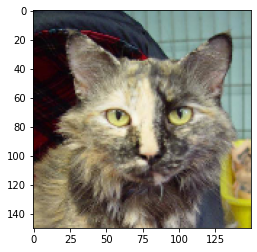

In [104]:
# load an example image, preprocess and display

img_path = "cat.10.jpg"
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# print(np.shape(img_tensor))

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# copy first layers of the model into a new model
# list output of these layers and select them as output of the new model
# the goal is show the intermediate activations

layer_outputs = [layer.output for layer in model.get_layer(index=0).layers[8:16]]
for layer in layer_outputs:
    print(layer)

activation_model = tf.keras.Model(inputs=model.get_layer(index=0).input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0,:,:,60], cmap='viridis')

In [ ]:
activation_model.summary()

In [ ]:
# To watch all the intermediate activation

# !mkdir image_layer
# print(len(model.get_layer(index=0).layers))

layer_names = []
for layer in model.get_layer(index=0).layers[8:16]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size:(row+1)*size] = channel_image

    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap = 'viridis')
    # plt.savefig("./image_layer/" + str(layer_name)+'.png')

## **VISUALISATION FILTER**

In [115]:
def deprocess_image(x):
    """
    function to normalize the filter array and convert it to image standard
    """
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    """
    generate the patern of a filter from a blank input image with gradient ascent
    - layer_name : name of the layerin which is the filter
    - filter_index : index of the filter among the other filters of the layer
    - return : image of the pattern
    """

    layer_output = model.get_layer(layer_name).output # select the output 
    loss = K.mean(layer_output[:,:,:, filter_index]) # compute the mean of the filter

    grads = K.gradients(loss, model.input)[0] # returns the gradients of loss w.r.t. variables
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # normalisation of the gradient to keep the magnitude in the same range

    iterate = K.function([model.input], [loss, grads]) # instantiates a Keras function (tensorflow 1)
    # loss_value, grads_value = iterate([np.zeros((1, size, size, 3))])

    input_img_data = np.random.random((1, size, size, 3))*20 +128  # random image
    step = 1.
    for i in range(40): # iterating the gradient ascent applying the function
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value*step
    img = input_img_data[0]
    
    return deprocess_image(img)

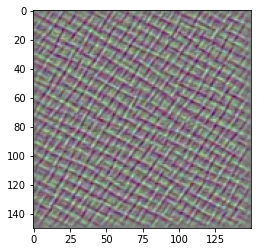

In [117]:
# Maximizing the response of a specific filter from a blank input image with gradient ascent

tf.compat.v1.disable_eager_execution()

model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 5

pattern = generate_pattern(layer_name, filter_index)
plt.imshow(pattern)

In [ ]:
# Maximizing the response of many filter from a blank input image with gradient ascent

layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8*size+7*margin, 8*size+7*margin, 3), np.uint8)

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + j*8, size=size)
        horizontal_start = i * size + i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        results[horizontal_start : horizontal_end, vertical_start : vertical_end, :] = filter_img

fig = plt.figure(figsize=(20, 20))
plt.imshow(results)

## **Visualisation of Heatmap**

In [ ]:
# load model, image and preprocess the image

model = VGG16(weights='imagenet')
img_path = './elephants.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [125]:
# observe prediction

preds = model.predict(x)
print('Predicted : ', decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

Predicted :  [('n02504458', 'African_elephant', 0.8493612), ('n01871265', 'tusker', 0.1340715), ('n02504013', 'Indian_elephant', 0.01655457)]


386

In [129]:
# GRAD CAM process

african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()
# plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


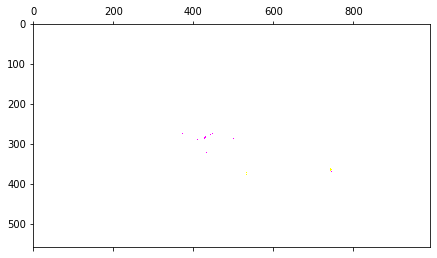

In [142]:
img = cv.imread('elephants.jpg')
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
superposed_img = heatmap*0.4+img
# cv.imwrite('elephants_cam.jpg', superposed_img)


## **TEST**

In [ ]:
# layer_name = 'block3_conv1'
# layer_output = model.get_layer(layer_name).output
# print(layer_output)

## **Visu weights**

In [68]:

sample_data = [i for i in range(1,10000)]
label_data = [2*i/20000 for i in range(1,10000)]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

inputs = tf.keras.Input(shape=(1,))
x0 = layers.Dense(1, kernel_initializer='Identity')(inputs)
x = layers.Dense(1)(x0)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', metrics=['mae'])
model.summary()
model.fit(sample_data, label_data, epochs=10, batch_size=1, callbacks=[tensorboard_callback], verbose=0)

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(model.predict([6000]))
2*6000/20000

In [ ]:
for layer in model.layers:
    print('\n\n   ',layer.name)
    print('\ninput :', layer.input)
    print('output :', layer.output)
    if layer.name != 'input_34':
        print('\nweights', layer.get_weights()[0])
        print('bias', layer.get_weights()[1])

In [79]:
x = 1000
print(((x*0.045-2.47)*(-0.046)+2)*(-0.047)+0.1)
print(2*x/20000)

0.09794986
0.1
